## BTC Model deployment

This notebook will import new data to feed into the trained LSTM model and produce csvs of close price and predictions.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import datetime as dt
from copy import deepcopy as dc
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
# from tensorflow.keras import layers
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.optimizers import Adam
from keras.models import load_model

from api_keys import coinapi_key

In [13]:
#  https://docs.coinapi.io/market-data/rest-api/ohlcv
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&&time_start=2023-01-02T00:00:00&limit=10000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-01-02T00:00:00.0000000Z', 'time_period_end': '2023-01-03T00:00:00.0000000Z', 'time_open': '2023-01-02T00:00:23.5020000Z', 'time_close': '2023-01-02T23:59:47.2190000Z', 'price_open': 16615, 'price_high': 16782, 'price_low': 16552, 'price_close': 16673, 'volume_traded': 1046.6584368, 'trades_count': 9780}, {'time_period_start': '2023-01-03T00:00:00.0000000Z', 'time_period_end': '2023-01-04T00:00:00.0000000Z', 'time_open': '2023-01-03T00:00:27.4330000Z', 'time_close': '2023-01-03T23:59:51.6650000Z', 'price_open': 16668, 'price_high': 16766, 'price_low': 16605, 'price_close': 16670, 'volume_traded': 1388.07196613, 'trades_count': 11861}, {'time_period_start': '2023-01-04T00:00:00.0000000Z', 'time_period_end': '2023-01-05T00:00:00.0000000Z', 'time_open': '2023-01-04T00:00:39.2340000Z', 'time_close': '2023-01-04T23:59:41.4680000Z', 'price_open': 16673, 'price_high': 16984, 'price_low': 16652, 'price_close': 16849, 'volume_traded': 2038.03012252, 'trades_count': 1

In [14]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-01-02T00:00:00.0000000Z,2023-01-03T00:00:00.0000000Z,2023-01-02T00:00:23.5020000Z,2023-01-02T23:59:47.2190000Z,16615,16782,16552,16673,1046.658437,9780
1,2023-01-03T00:00:00.0000000Z,2023-01-04T00:00:00.0000000Z,2023-01-03T00:00:27.4330000Z,2023-01-03T23:59:51.6650000Z,16668,16766,16605,16670,1388.071966,11861
2,2023-01-04T00:00:00.0000000Z,2023-01-05T00:00:00.0000000Z,2023-01-04T00:00:39.2340000Z,2023-01-04T23:59:41.4680000Z,16673,16984,16652,16849,2038.030123,15672
3,2023-01-05T00:00:00.0000000Z,2023-01-06T00:00:00.0000000Z,2023-01-05T00:00:05.6030000Z,2023-01-05T23:59:29.2900000Z,16847,16871,16755,16826,1129.003529,10216
4,2023-01-06T00:00:00.0000000Z,2023-01-07T00:00:00.0000000Z,2023-01-06T00:00:22.2310000Z,2023-01-06T23:59:32.5910000Z,16826,17024,16669,16950,1728.756840,12381


In [15]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
# data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data

,Close
Date,
2023-01-02,16673
2023-01-03,16670
2023-01-04,16849
2023-01-05,16826
2023-01-06,16950
...,...
2023-09-10,25836
2023-09-11,25155
2023-09-12,25844


In [16]:
close = data['Close']

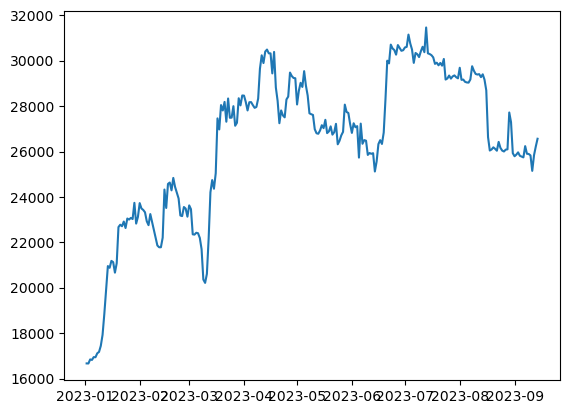

In [17]:
#plot historical eth price
plt.plot(close)

In [18]:
# build 1 month lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6)
Date,,,,,,,
2023-01-08,17119,16945.0,16950.0,16826.0,16849.0,16670.0,16673.0
2023-01-09,17179,17119.0,16945.0,16950.0,16826.0,16849.0,16670.0
2023-01-10,17446,17179.0,17119.0,16945.0,16950.0,16826.0,16849.0
2023-01-11,17930,17446.0,17179.0,17119.0,16945.0,16950.0,16826.0
2023-01-12,18853,17930.0,17446.0,17179.0,17119.0,16945.0,16950.0
...,...,...,...,...,...,...,...
2023-09-10,25836,25899.0,25908.0,26245.0,25748.0,25783.0,25819.0
2023-09-11,25155,25836.0,25899.0,25908.0,26245.0,25748.0,25783.0
2023-09-12,25844,25155.0,25836.0,25899.0,25908.0,26245.0,25748.0


In [41]:
#create array of dates for plotting from new index. 
dates = shifted_df.index

dates.shape

(246,)

In [20]:
#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np


shifted_df_as_np_int = shifted_df_as_np.astype(int)
log_transformed_data = np.log(shifted_df_as_np_int)

log_transformed_data.shape

(246, 7)

In [21]:
#load trained model
model = load_model("H5_Files/btc_7_day.h5")

In [34]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = log_transformed_data[-1].reshape((1, 7, 1))
initial_date = dates[-1]

for i in range(prediction_range):  # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_batch)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        
    # Shift the current batch one step forward
    current_batch = np.roll(current_batch, shift=-1, axis=1)
    current_batch[0, -1, 0] = current_pred
    

    
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
#'predictions' contains forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 26ms/step
[10.163085, 10.165382, 10.168213, 10.171077, 10.173105, 10.175451, 10.17789]
2023-09-15
2023-09-16
2023-09-17
2023-09-18
2023-09-19
2023-09-20
2023-09-21


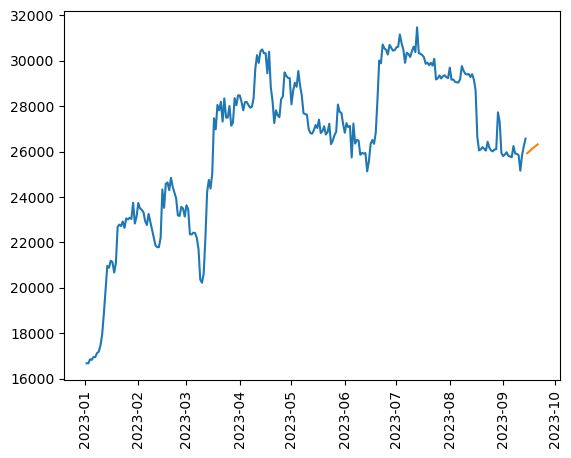

In [35]:
plt.plot(close)
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)

plt.show()

In [36]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates, "observed":close[lookback:]})
df.set_index('Date', inplace=True)

df2 = pd.DataFrame({"Date": predicted_dates, "future_prediction":np.exp(predictions)})
df2.set_index('Date', inplace=True)                   
                    
past_future_df = pd.merge(df,df2, how='outer', left_index=True, right_index=True)


past_future_df.head()


,observed,future_prediction
Date,,
2023-01-08,17119.0,NaN
2023-01-09,17179.0,NaN
2023-01-10,17446.0,NaN
2023-01-11,17930.0,NaN
2023-01-12,18853.0,NaN


In [37]:
past_future_df.tail()



,observed,future_prediction
Date,,
2023-09-17,NaN,26061.458984
2023-09-18,NaN,26136.205078
2023-09-19,NaN,26189.271484
2023-09-20,NaN,26250.787109
2023-09-21,NaN,26314.878906


In [38]:
past_df = pd.read_csv('output/btc_model.csv')

past_df = past_df[["future_prediction"]]

past_df = past_df.rename(columns={"future_prediction":"past_pred"})

df_combined = pd.merge(past_future_df,past_df, how='outer', left_index=True, right_index=True)

df_combined.head()

,observed,future_prediction,past_pred
2023-01-08,17119.0,NaN,NaN
2023-01-09,17179.0,NaN,NaN
2023-01-10,17446.0,NaN,NaN
2023-01-11,17930.0,NaN,NaN
2023-01-12,18853.0,NaN,NaN


In [39]:
past_future_df.to_csv('output/btc_model.csv') 

In [40]:
df_combined.to_csv('output/btc_model_hist.csv') 